In [1]:
import cobra

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from itertools import product

# Alter model bounds
We set model bounds to allow for growth limitation in a replete nutrient environment by limiting RuBisCO usage to 4.7mmol/gDW/h following Casey et al, and we remove other uptake bounds. We verify that growth is limited, and we can use this maximum growth as a normalization factor.

In [2]:
REGENERATE_MODEL = False
if REGENERATE_MODEL:
    model_original = cobra.io.read_sbml_model("model_files/iJB785.xml")
    with model_original as rl_model:
        old_obj = rl_model.slim_optimize()
        print(f"Old objective value: {old_obj}")
        for rxn in rl_model.reactions:
            lb, ub = rxn.bounds
            if lb < 0 and lb != -1000:
                print(f"Setting {rxn.id} lower bound from {lb} to -1000")
                rxn.lower_bound = -1000
            if lb > 0:
                print(f"Setting {rxn.id} lower bound from {lb} to 0")
                rxn.lower_bound = 0
            if ub > 0 and ub != 1000:
                print(f"Setting {rxn.id} upper bound from {ub} to 1000")
                rxn.upper_bound = 1000
            if ub < 0:
                print(f"Setting {rxn.id} upper bound from {ub} to 0")
        print("Setting RuBisCO rxn (RBPCcx) bounds manually")
        rl_model.reactions.get_by_id("RBPCcx").bounds = 0, 4.7

        print("Double checking bounds...")
        for rxn in rl_model.reactions:
            lb, ub = rxn.bounds
            if lb not in [-1000, 0] or ub not in [1000, 0]:
                print(f"{rxn.id} has bounds {lb}, {ub}")

        rl_obj = rl_model.slim_optimize()
        print(f"Objective value: {rl_obj}")

        cobra.io.write_sbml_model(rl_model, "model_files/iJB785_rubisco_limited.xml")
model = cobra.io.read_sbml_model("model_files/iJB785_rubisco_limited.xml")
opt = model.slim_optimize()
opt

0.1145315229684554

# Nutrient limit CP12 predictions
We will use FBA to make predictions about growth rate response to nutrient limitation and CP12. We will compare to N-limitation experiments.

### Display baseline ranges for relevant reaction rates
GAPDi_nadp and PRUK are catalyzed by enzymes that CP12 sequesters. PSIum and PSIIum are related to light absorption (note that photodamage is not explicitly modeled). EX_pi_e, EX_no3_e, and EX_nh4_e denote phosphate, nitrate, and ammonium uptake, respectively.

In [3]:
cobra.flux_analysis.flux_variability_analysis(
    model,
    fraction_of_optimum=1,
    reaction_list=[
        model.reactions.GAPDi_nadp,
        model.reactions.PRUK,
        model.reactions.PSIum,
        model.reactions.PSIIum,
        model.reactions.EX_pi_e,
        model.reactions.EX_no3_e,
        model.reactions.EX_nh4_e,
    ],
)

,minimum,maximum
GAPDi_nadp,8.673423,1.000000e+03
PRUK,4.700000,4.700000e+00
PSIum,20.538567,1.000000e+03
PSIIum,5.147201,2.500000e+02
EX_pi_e,-0.048871,-4.887076e-02
EX_no3_e,-0.862779,0.000000e+00
EX_nh4_e,-0.862779,-4.667316e-15


In [4]:
# fixed values are chosen manually from the above to ensure reproducibility
pmax = -0.049
n3max = -0.863
n4max = -0.863
lmax1 = 20.538567
lmax2 = 5.147201

### Run FBA simulations
We run N and P limited FBA optimization with and without simulated *cp12* overexpression mutation (modeled as decreased flux through GAPDi_nadp and PRUK) and in high and low light conditions. We compute the log2 fold change between the mutant and wild type and will plot this later along with the experiment data.

In [5]:
lfrac_low = 0.6
nsteps = 21
gap_lim = 8.673423 * 0.2
pru_lim = 4.7 * 0.2
limit_mat_base = np.matrix(np.zeros((nsteps, nsteps)))
with model as limited:
    for (pind, plim), (nind, nlim) in product(
        enumerate(np.linspace(0, 1, nsteps)), repeat=2
    ):
        limited.reactions.EX_pi_e.bounds = (plim * pmax, 0)
        limited.reactions.EX_no3_e.bounds = (nlim * n3max, 0)
        limited.reactions.EX_nh4_e.bounds = (nlim * n4max, 0)
        obj = limited.slim_optimize()
        limit_mat_base[pind, nind] = obj

limit_mat_cp12 = np.matrix(np.zeros((nsteps, nsteps)))
with model as limited:
    for (pind, plim), (nind, nlim) in product(
        enumerate(np.linspace(0, 1, nsteps)), repeat=2
    ):
        limited.reactions.GAPDi_nadp.bounds = (0, gap_lim)
        limited.reactions.PRUK.bounds = (0, pru_lim)
        limited.reactions.EX_pi_e.bounds = (plim * pmax, 0)
        limited.reactions.EX_no3_e.bounds = (nlim * n3max, 0)
        limited.reactions.EX_nh4_e.bounds = (nlim * n4max, 0)
        obj = limited.slim_optimize()
        limit_mat_cp12[pind, nind] = obj

limit_mat_base_ll = np.matrix(np.zeros((nsteps, nsteps)))
with model as limited:
    for (pind, plim), (nind, nlim) in product(
        enumerate(np.linspace(0, 1, nsteps)), repeat=2
    ):
        limited.reactions.EX_pi_e.bounds = (plim * pmax, 0)
        limited.reactions.EX_no3_e.bounds = (nlim * n3max, 0)
        limited.reactions.EX_nh4_e.bounds = (nlim * n4max, 0)
        limited.reactions.PSIum.bounds = (0, lmax1 * lfrac_low)
        limited.reactions.PSIIum.bounds = (0, lmax2 * lfrac_low)
        obj = limited.slim_optimize()
        limit_mat_base_ll[pind, nind] = obj

limit_mat_cp12_ll = np.matrix(np.zeros((nsteps, nsteps)))
with model as limited:
    for (pind, plim), (nind, nlim) in product(
        enumerate(np.linspace(0, 1, nsteps)), repeat=2
    ):
        limited.reactions.GAPDi_nadp.bounds = (0, gap_lim)
        limited.reactions.PRUK.bounds = (0, pru_lim)
        limited.reactions.EX_pi_e.bounds = (plim * pmax, 0)
        limited.reactions.EX_no3_e.bounds = (nlim * n3max, 0)
        limited.reactions.EX_nh4_e.bounds = (nlim * n4max, 0)
        limited.reactions.PSIum.bounds = (0, lmax1 * lfrac_low)
        limited.reactions.PSIIum.bounds = (0, lmax2 * lfrac_low)
        obj = limited.slim_optimize()
        limit_mat_cp12_ll[pind, nind] = obj

slice_pos = -(nsteps // 2)
fc_start_pos = nsteps - 9
fc_end_pos = nsteps - 1
log2fc = (
    np.log2((limit_mat_cp12)[slice_pos, 1:]) - np.log2((limit_mat_base)[slice_pos, 1:])
).tolist()[0][::-1]
log2fc_ll = (
    np.log2((limit_mat_cp12_ll)[slice_pos, 1:])
    - np.log2((limit_mat_base_ll)[slice_pos, 1:])
).tolist()[0][::-1]
xvals = np.linspace(0, 1, nsteps)[fc_start_pos:fc_end_pos] * (n3max + n4max)

fva_fit = [
    xvals,
    log2fc[fc_start_pos:fc_end_pos][::-1],
    log2fc_ll[fc_start_pos:fc_end_pos][::-1],
]

# Repeat for MED4
We repeat the analysis for MED4 and compare the results qualitatively. Note that MED4 does not uptake NO3.

In [6]:
model_med4 = cobra.io.read_sbml_model("model_files/ProchlorococcusMED4+PHM2v1.xml")
opt_med4 = model_med4.slim_optimize()
opt_med4

0.09846248800237188

In [7]:
cobra.flux_analysis.flux_variability_analysis(
    model_med4,
    fraction_of_optimum=1,
    reaction_list=[
        model_med4.reactions.R01063,
        model_med4.reactions.R01523,
        model_med4.reactions.PSIIabs,
        model_med4.reactions.FAKEOrthophosphateEX,
        model_med4.reactions.AmmoniaEX,
    ],
)

,minimum,maximum
R01063,-1000.000000,991.061558
R01523,4.700000,4.700000
PSIIabs,23.247811,976.734297
FAKEOrthophosphateEX,-0.033099,-0.033099
AmmoniaEX,-0.864117,-0.855149


In [8]:
pmax_med4 = -0.0331
n4max_med4 = -0.865

In [9]:
nsteps = 21
limit_mat_base_med4 = np.matrix(np.zeros((nsteps, nsteps)))
with model_med4 as limited:
    for (pind, plim), (nind, nlim) in product(
        enumerate(np.linspace(0, 1, nsteps)), repeat=2
    ):
        limited.reactions.FAKEOrthophosphateEX.bounds = (plim * pmax_med4, 0)
        limited.reactions.AmmoniaEX.bounds = (nlim * n4max_med4, 0)
        obj = limited.slim_optimize()
        limit_mat_base_med4[pind, nind] = obj

limit_mat_cp12_med4 = np.matrix(np.zeros((nsteps, nsteps)))
gap_lim = 8.673423 * 0.2
pru_lim = 4.7 * 0.2
with model_med4 as limited:
    for (pind, plim), (nind, nlim) in product(
        enumerate(np.linspace(0, 1, nsteps)), repeat=2
    ):
        limited.reactions.R01063.bounds = (0, gap_lim)
        limited.reactions.R01523.bounds = (0, pru_lim)
        limited.reactions.FAKEOrthophosphateEX.bounds = (plim * pmax_med4, 0)
        limited.reactions.AmmoniaEX.bounds = (nlim * n4max_med4, 0)

        obj = limited.slim_optimize()
        limit_mat_cp12_med4[pind, nind] = obj


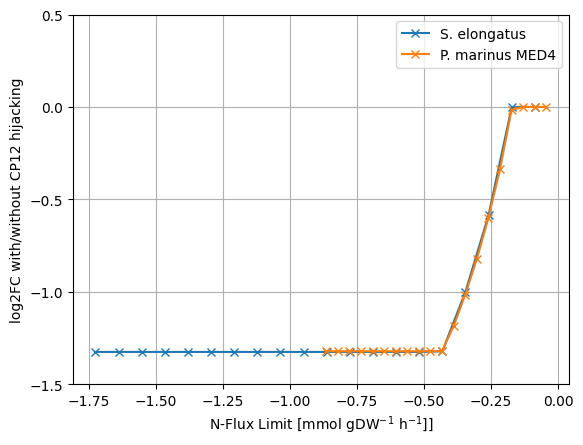

In [10]:
fig, ax = plt.subplots(1, 1)
slice_pos = 10
slice_pos_med4 = 10
fc_start_pos = 20
fc_start_pos_med4 = 20
log2fc = (
    np.log2((limit_mat_cp12)[slice_pos, 1:]) - np.log2((limit_mat_base)[slice_pos, 1:])
).tolist()[0][::-1]
log2fc_med4 = (
    np.log2((limit_mat_cp12_med4)[slice_pos_med4, 1:])
    - np.log2((limit_mat_base_med4)[slice_pos_med4, 1:])
).tolist()[0][::-1]
xvals = np.linspace(0, 1, nsteps)[-fc_start_pos:] * (n3max + n4max)
xvals_med4 = np.linspace(0, 1, nsteps)[-fc_start_pos:] * (n4max_med4)
ax.plot(xvals, log2fc[-fc_start_pos:][::-1], "-x", label="S. elongatus")
ax.plot(xvals_med4, log2fc_med4[-fc_start_pos:][::-1], "-x", label="P. marinus MED4")
ax.set_xlabel("N-Flux Limit [mmol gDW$^{-1}$ h$^{-1}]$]")
# ax.set_xticks(xvals)
# ax.set_xticklabels([f"{x:.2f}" for x in np.abs(xvals)])
ax.set_yticks(np.arange(-1.5, 0.6, 0.5))
ax.set_ylabel("log2FC with/without CP12 hijacking")
# ax.set_ylim(-1.6, 0.6)
ax.legend()
ax.grid()
fig.savefig("figures/N_limit_med4-elongatus_comparison.png")
plt.show()

### description of data table

`Se7942_WT_cp12_NP_limit_Bohutskyi.xlsx` has two sheets: `Metadata` and `Data`. For data analysis, we need only import `Data`. This consists of several tables placed in the same sheet, in a grid. 

There are 14 rows and 6 columns of tables, each with 12 columns and 8 rows (not counting header & index) that correspond to locations on a 96 well plate. There is some buffer space between these tables. Table $(i,j)$ begins on row $3+12i$ and column $1+15j$ (everything zero-indexed here). 

The tables are arranged such that the tables in the first three columns are N-limiting (high, med, low light), and the last three columns are P-limiting (same light condition ordering). Each row of tables is a different time-point, aranged top-to-bottom in increasing time. The time points are not equally spaced (see `times` array, which is in hours).

The first 4 rows in each table are wild-type, the last 4 are mutant. The columns of each table are aranged left-to-right in order of decreasing nutrient availability. The last column of each table is water-only for evaporation control and should be discarded. 


In [11]:
tables = pd.read_excel(
    "data/Se7942_WT_cp12_NP_limit_Bohutskyi.xlsx",
    sheet_name="Data",
    header=None,
    index_col=None,
)


In [12]:
times = [  # growth time in hours
    0,
    15.0,
    19.6,
    25.5,
    38.8,
    44.6,
    50.5,
    62.9,
    68.8,
    74.9,
    87.5,
    97.3,
    111.3,
    120.1,
    135.2,
]
N_CONCENTRATIONS = [1500, 1200, 800, 400, 200, 120, 60, 30, 15, 0]  # NaNO3 in mg/L
P_CONCENTRATIONS = [40, 20, 16, 12, 8, 6, 4, 2, 1, 0]  # K2HPO4 in mg/L
N_TIME_POINTS = 15
N_LIMIT_VALUES = 10
N_CONDITIONS = 6
ROW_OFFSET = 3
ROW_JUMP = 12
COL_OFFSET = 1
COL_JUMP = 15
N_REPLICATES_PER_PLATE = 4
DATA_START_COL = 1
DATA_END_COL = 1 + N_LIMIT_VALUES
conditions = [
    "N-limit, high light",
    "N-limit, medium light",
    "N-limit, low light",
    "P-limit, high light",
    "P-limit, medium light",
    "P-limit, low light",
]  # N-limited, high, medium, low light, and same for P-limited, same order as in spreadsheet


In [13]:
cond_data = {condition: [] for condition in conditions}

for t, j in product(range(N_TIME_POINTS), range(N_CONDITIONS)):
    condition = conditions[j]

    # top left point in table; this will be a "water-only" column, so we add one
    r0_wt = ROW_OFFSET + t * ROW_JUMP
    r0_mt = r0_wt + N_REPLICATES_PER_PLATE
    c0 = COL_OFFSET + j * COL_JUMP + DATA_START_COL

    rm_wt = r0_wt + N_REPLICATES_PER_PLATE
    rm_mt = r0_mt + N_REPLICATES_PER_PLATE
    cm = COL_OFFSET + j * COL_JUMP + DATA_END_COL

    wt_blank = np.broadcast_to(
        [
            (
                (tables.iloc[r0_wt:rm_wt, c0 - 1] + tables.iloc[r0_wt:rm_wt, cm]) / 2
            ).to_numpy()
        ],
        (N_LIMIT_VALUES, N_REPLICATES_PER_PLATE),
    ).T
    wt = tables.iloc[r0_wt:rm_wt, c0:cm].to_numpy() - wt_blank
    mt_blank = np.broadcast_to(
        [
            (
                (tables.iloc[r0_mt:rm_mt, c0 - 1] + tables.iloc[r0_mt:rm_mt, cm]) / 2
            ).to_numpy()
        ],
        (N_LIMIT_VALUES, N_REPLICATES_PER_PLATE),
    ).T
    mt = tables.iloc[r0_mt:rm_mt, c0:cm].to_numpy() - mt_blank

    cond_data[condition].append([wt, mt])  # will be time-ordered

cond_data = {condition: np.array(data) for condition, data in cond_data.items()}
print(
    "for each condition, we now have a 4-d array, with dimensions corresponding to time, mutant, replicate, limit:"
)
print(cond_data[conditions[0]].shape)

for each condition, we now have a 4-d array, with dimensions corresponding to time, mutant, replicate, limit:
(15, 2, 4, 10)


### Define curve fits and parameter error functions

In [14]:
def logistic(
    t,
    carrying_capacity,
    growth_rate,
    t_half,
    vshift,
):  # t_half is also time of max growth
    return vshift + carrying_capacity / (1 + np.exp(growth_rate * (t_half - t)))


def max_growth(carrying_capacity, growth_rate, vshift=None, specific=False):
    gr = growth_rate * carrying_capacity / 4
    if specific:
        gr = gr / (carrying_capacity / 2 + vshift)
    return gr


def max_growth_error(pcov, carrying_capacity, growth_rate, vshift=None, specific=False):
    v_cc = pcov[0, 0]
    v_gr = pcov[1, 1]
    v_vs = pcov[3, 3]

    if specific:
        dmdg = carrying_capacity / (4 * (carrying_capacity / 2 + vshift))
        dmdc = (
            growth_rate / (4 * (carrying_capacity / 2 + vshift))
            - 2
            * growth_rate
            * carrying_capacity
            / (4 * (carrying_capacity / 2 + vshift)) ** 2
        )
        dmdv = (
            -4
            * growth_rate
            * carrying_capacity
            / (4 * (carrying_capacity / 2 + vshift)) ** 2
        )
    else:
        dmdg = carrying_capacity / 4
        dmdc = growth_rate / 4
        dmdv = 0
    return np.sqrt(v_cc * dmdc**2 + v_gr * dmdg**2 + v_vs * dmdv**2)

### Perform curve fitting on experiment data set

In [15]:
curve_fits = {}
covs = {}
for condition, limit, rep, m in product(
    conditions, range(N_LIMIT_VALUES), range(N_REPLICATES_PER_PLATE), range(2)
):
    # we'll define replicate number such that lower = closer to edge of plate
    od = cond_data[condition][:, m, int(rep - m * (2 * rep + 1)), limit]

    tfit = times[: np.argmax(od) + 2]
    od = od[: np.argmax(od) + 2]

    min_cc = max(0, (max(od) - min(od)) * 0.8)
    max_cc = max(0, (max(od) - min(od)) * 1.2)
    guess_cc = max(0, max(od) - min(od))

    min_gr = max(0, (max(od) - min(od)) * (min(tfit) - max(tfit)))
    max_gr = np.inf
    guess_gr = max(0, np.max(np.diff(od) / np.diff(tfit)) * 4 / guess_cc)

    min_t_half = tfit[0]
    max_t_half = tfit[-1]
    guess_t_half = times[np.argmax(np.diff(od) / np.diff(tfit))]

    min_vshift = max(0, min(od) * 0.8)
    max_vshift = max(0, min(od) * 1.2)
    guess_vshift = max(0, min(od))

    try:
        (carrying_capacity, growth_rate, t_half, vshift), pcov = sp.optimize.curve_fit(
            logistic,
            tfit,
            od,
            p0=[guess_cc, guess_gr, guess_t_half, guess_vshift],
            bounds=(
                [min_cc, min_gr, min_t_half, min_vshift],
                [max_cc, max_gr, max_t_half, max_vshift],
            ),
            maxfev=1_000_000,
        )
    except RuntimeError:
        (carrying_capacity, growth_rate, t_half, vshift) = [np.nan] * 4
        pcov = None

    curve_fits[(condition, limit, rep, m)] = (
        carrying_capacity,
        growth_rate,
        t_half,
        vshift,
    )
    covs[(condition, limit, rep, m)] = pcov

C:\Users\rozu775\AppData\Local\Temp\ipykernel_18032\961311349.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  (carrying_capacity, growth_rate, t_half, vshift), pcov = sp.optimize.curve_fit(
C:\Users\rozu775\AppData\Local\Temp\ipykernel_18032\114582443.py:8: RuntimeWarning: overflow encountered in exp
  return vshift + carrying_capacity / (1 + np.exp(growth_rate * (t_half - t)))


### Plot growth curves and fits

(15, 4, 10)


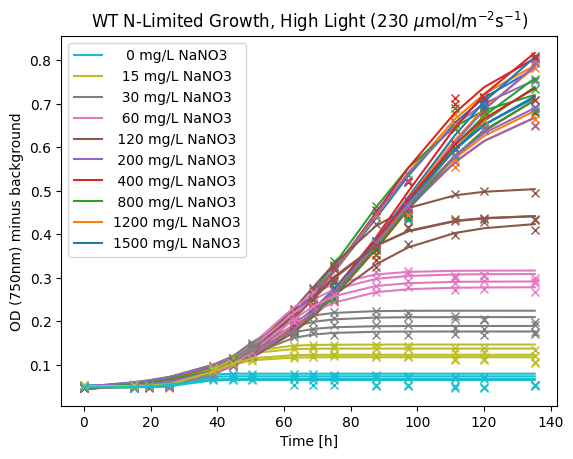

In [16]:
wt = cond_data[conditions[0]][:, 0, :, :]
print(wt.shape)

for replicate in range(wt.shape[1]):
    for limit in range(wt.shape[2]):
        (
            carrying_capacity,
            growth_rate,
            t_half,
            vshift,
        ) = curve_fits[(conditions[0], limit, replicate, 0)]
        plt.plot(
            times,
            wt[:, replicate, limit],
            marker="x",
            linestyle="None",
            color=f"C{limit}",
        )
        plt.plot(
            times,
            logistic(times, carrying_capacity, growth_rate, t_half, vshift),
            color=f"C{limit}",
            label=f"{N_CONCENTRATIONS[limit]:>4} mg/L NaNO3"
            if replicate == 0
            else None,
        )
plt.legend(reverse=True)
plt.title(r"WT N-Limited Growth, High Light (230 $\mu$mol/m$^{-2}$s$^{-1}$)")
plt.xlabel("Time [h]")
plt.ylabel("OD (750nm) minus background")
plt.savefig("figures/growth_wt_high_light.png")
plt.show()


(15, 4, 10)


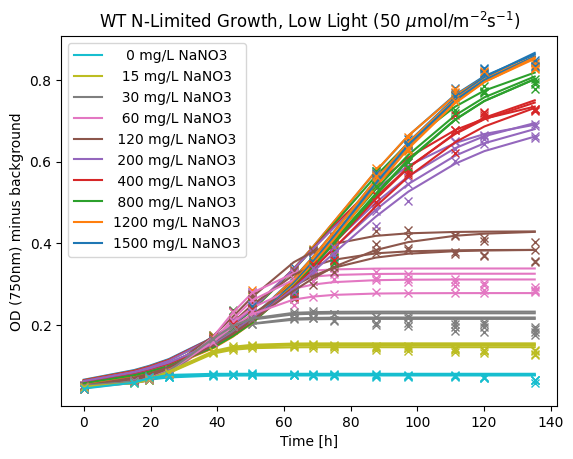

In [17]:
wt = cond_data[conditions[2]][:, 0, :, :]
print(wt.shape)

for replicate in range(wt.shape[1]):
    for limit in range(wt.shape[2]):
        (
            carrying_capacity,
            growth_rate,
            t_half,
            vshift,
        ) = curve_fits[(conditions[2], limit, replicate, 0)]
        plt.plot(
            times,
            wt[:, replicate, limit],
            marker="x",
            linestyle="None",
            color=f"C{limit}",
        )
        plt.plot(
            times,
            logistic(times, carrying_capacity, growth_rate, t_half, vshift),
            color=f"C{limit}",
            label=f"{N_CONCENTRATIONS[limit]:>4} mg/L NaNO3"
            if replicate == 0
            else None,
        )
plt.legend(reverse=True)
plt.title(r"WT N-Limited Growth, Low Light (50 $\mu$mol/m$^{-2}$s$^{-1}$)")
plt.xlabel("Time [h]")
plt.ylabel("OD (750nm) minus background")
plt.savefig("figures/growth_wt_lowlight.png")
plt.show()


(15, 4, 10)


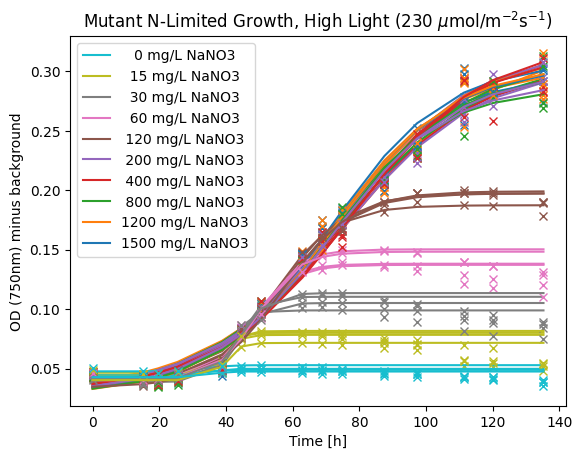

In [18]:
mt = cond_data[conditions[0]][:, 1, :, :]
print(mt.shape)

for replicate in range(mt.shape[1]):
    for limit in range(mt.shape[2]):
        (
            carrying_capacity,
            growth_rate,
            t_half,
            vshift,
        ) = curve_fits[(conditions[0], limit, replicate, 1)]
        plt.plot(
            times,
            mt[:, replicate, limit],
            marker="x",
            linestyle="None",
            color=f"C{limit}",
        )
        plt.plot(
            times,
            logistic(times, carrying_capacity, growth_rate, t_half, vshift),
            color=f"C{limit}",
            label=f"{N_CONCENTRATIONS[limit]:>4} mg/L NaNO3"
            if replicate == 0
            else None,
        )
plt.legend(reverse=True)
plt.title(r"Mutant N-Limited Growth, High Light (230 $\mu$mol/m$^{-2}$s$^{-1}$)")
plt.xlabel("Time [h]")
plt.ylabel("OD (750nm) minus background")
plt.savefig("figures/growth_mutant_highlight.png")
plt.show()

(15, 4, 10)


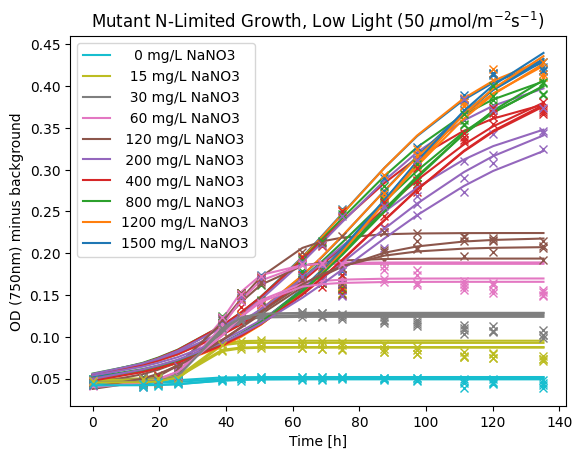

In [19]:
mt = cond_data[conditions[2]][:, 1, :, :]
print(mt.shape)

for replicate in range(mt.shape[1]):
    for limit in range(mt.shape[2]):
        (
            carrying_capacity,
            growth_rate,
            t_half,
            vshift,
        ) = curve_fits[(conditions[2], limit, replicate, 1)]
        plt.plot(
            times,
            mt[:, replicate, limit],
            marker="x",
            linestyle="None",
            color=f"C{limit}",
        )
        plt.plot(
            times,
            logistic(times, carrying_capacity, growth_rate, t_half, vshift),
            color=f"C{limit}",
            label=f"{N_CONCENTRATIONS[limit]:>4} mg/L NaNO3"
            if replicate == 0
            else None,
        )
plt.legend(reverse=True)
plt.title(r"Mutant N-Limited Growth, Low Light (50 $\mu$mol/m$^{-2}$s$^{-1}$)")
plt.xlabel("Time [h]")
plt.ylabel("OD (750nm) minus background")
plt.savefig("figures/growth_mutant_lowlight.png")
plt.show()

### Compare FBA to experiments
We plot the mutant vs WT log2FC in maximum grwoth rates derived from the logistic fits as a function of N availability alongside the FBA-predicted values for different N-flux values.

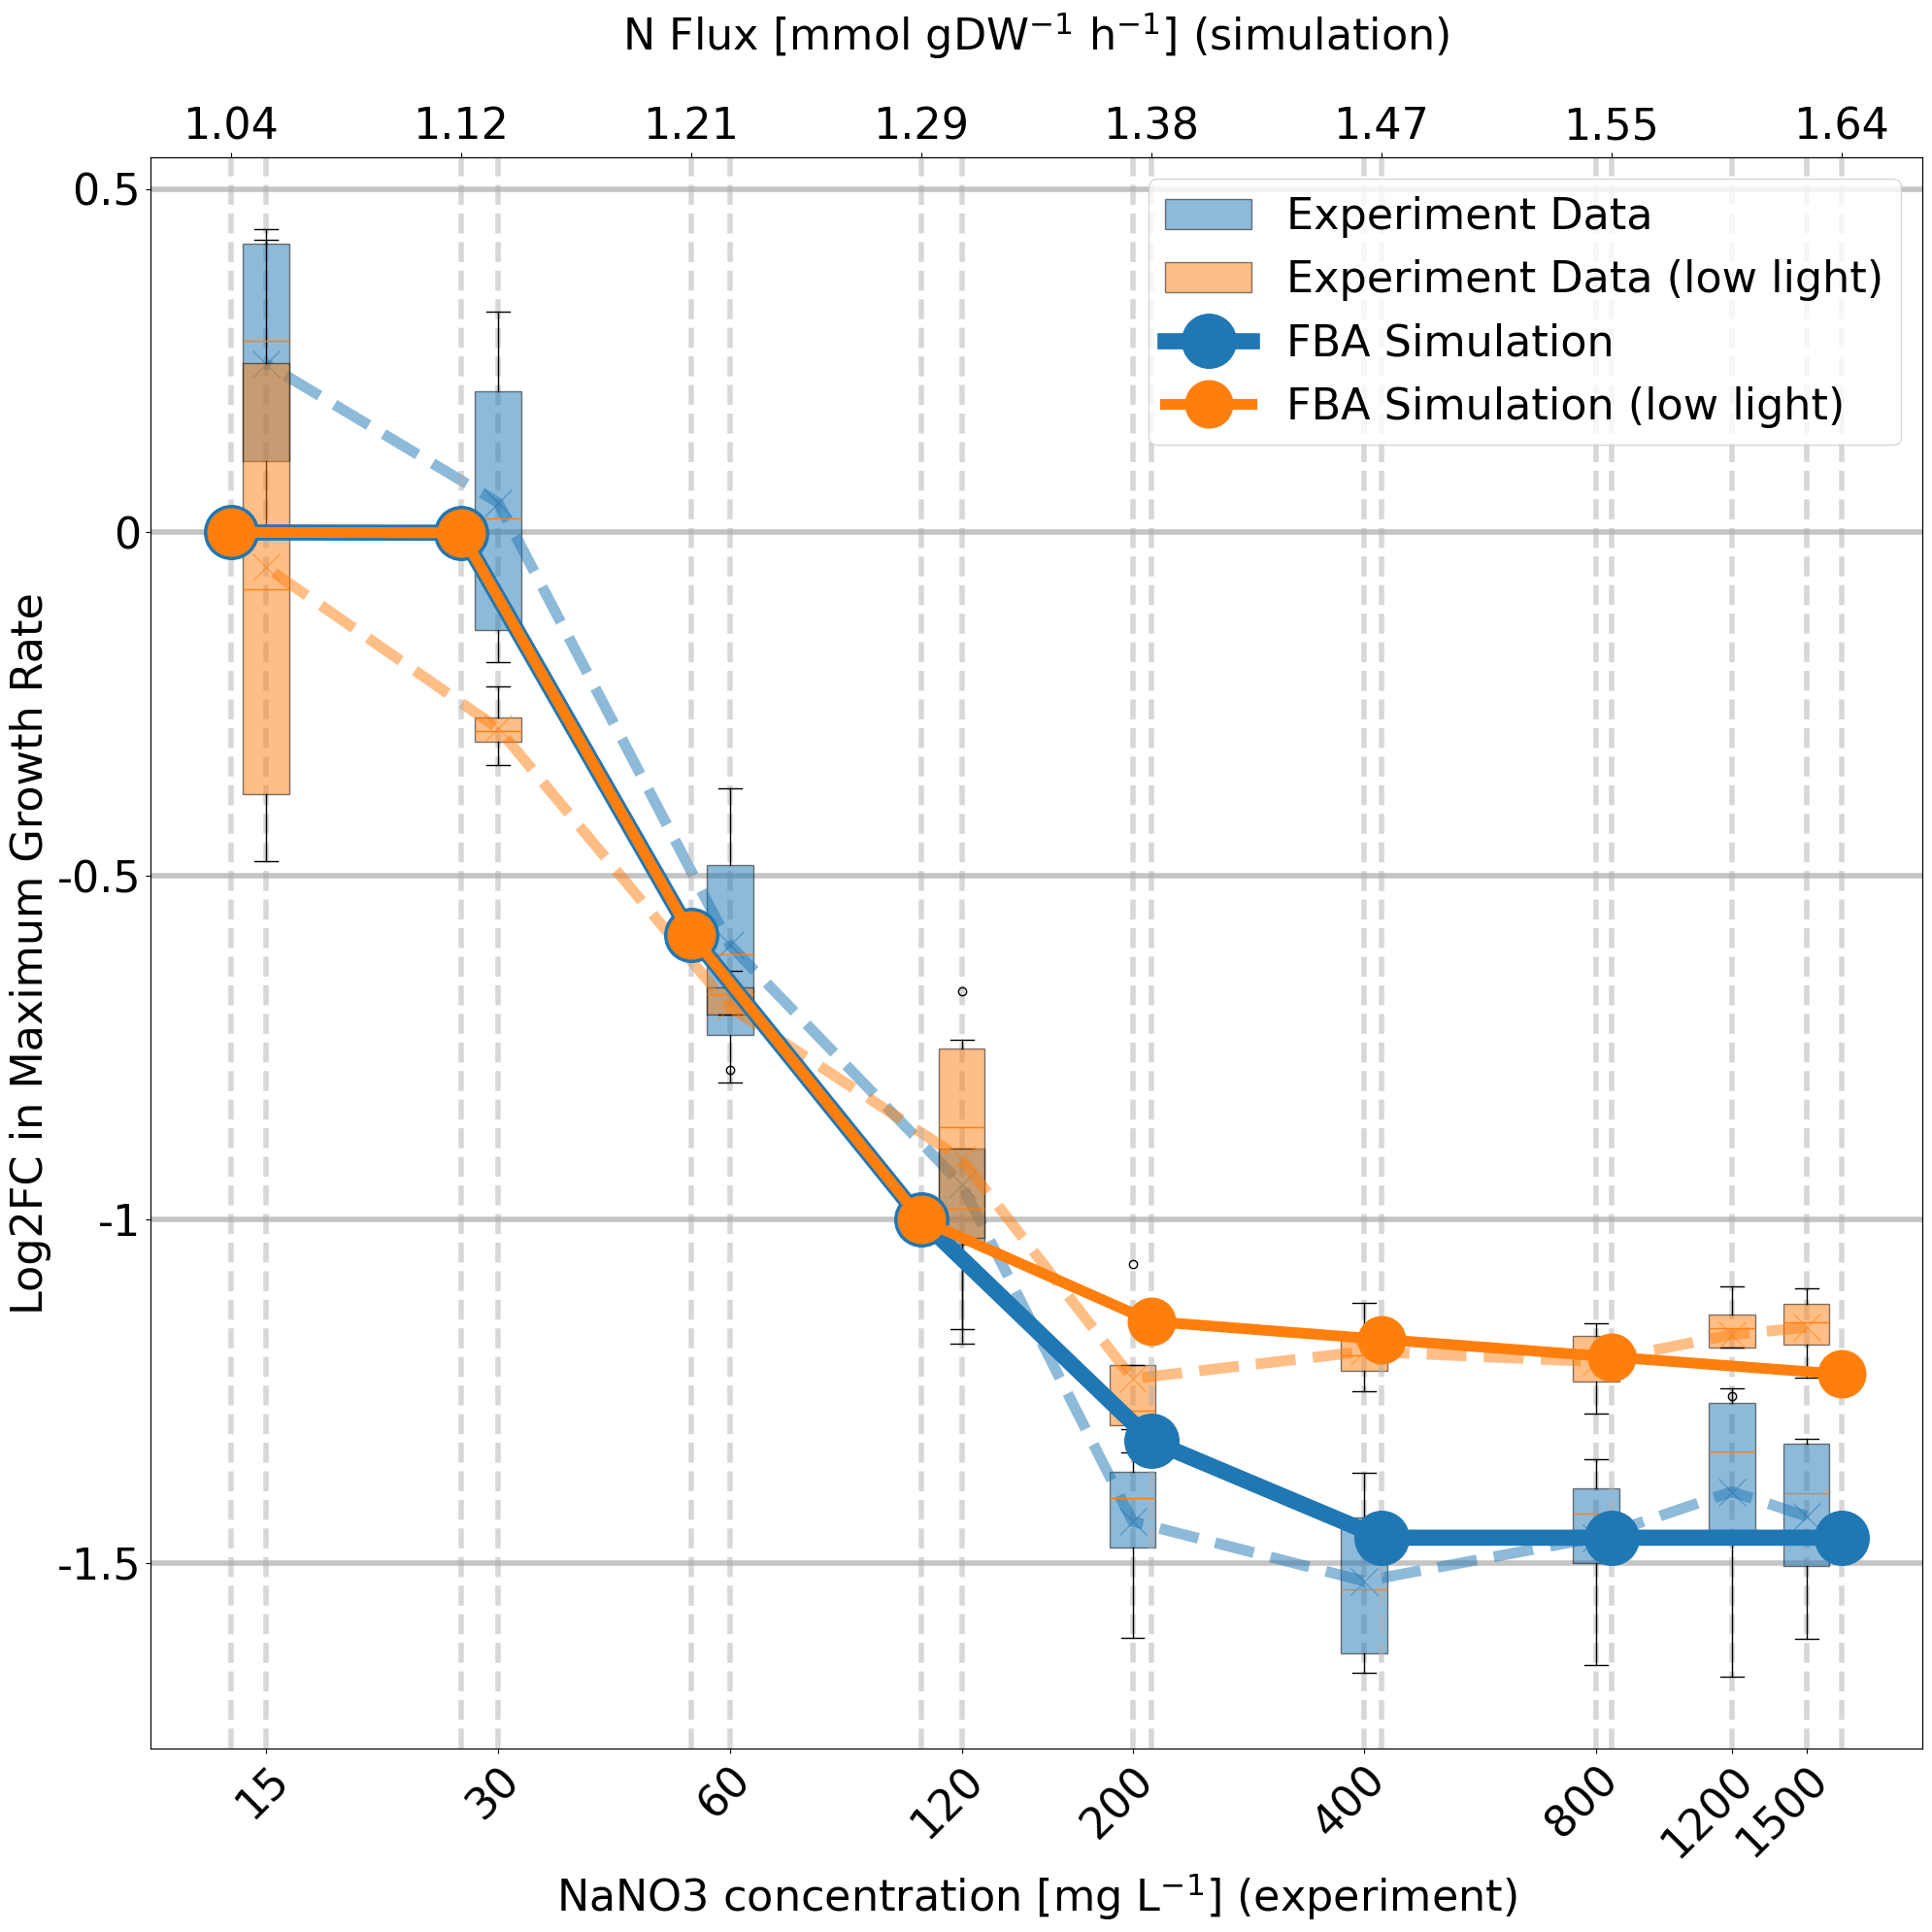

In [20]:
specific = False
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax2 = plt.twiny(ax)
fs = 32
for c, condition, label_suffix in [
    (0, "N-limit, high light", ""),
    (1, "N-limit, low light", " (low light)"),
]:
    growths_wt = []
    growths_mt = []
    limit_vals_wt = []
    limit_vals_mt = []
    for limit, rep, m in product(
        range(N_LIMIT_VALUES), range(N_REPLICATES_PER_PLATE), range(2)
    ):
        od = cond_data[condition][:, m, rep, limit]

        (
            carrying_capacity,
            growth_rate,
            t_half,
            vshift,
        ) = curve_fits[(condition, limit, rep, m)]
        pcov = covs[(condition, limit, rep, m)]
        mg = max_growth(
            carrying_capacity, growth_rate, vshift=vshift, specific=specific
        )
        mge = max_growth_error(
            pcov, carrying_capacity, growth_rate, vshift=vshift, specific=specific
        )
        if (mge > mg / 2) or np.isnan(mge):
            mg = np.nan
        if m == 0:
            growths_wt.append(mg)
            limit_vals_wt.append(limit)
        else:
            growths_mt.append(mg)
            limit_vals_mt.append(limit)
    growths_wt = np.array(growths_wt)
    growths_mt = np.array(growths_mt)

    dgrowth = np.log2(growths_mt) - np.log2(growths_wt)
    # dgrowth[np.abs(dgrowth) > 3] = np.nan

    box_dict = {}
    for dg, lim in zip(dgrowth, limit_vals_wt):
        box_dict.setdefault(lim, []).append(dg)
    bp = ax.boxplot(
        [v for k, v in sorted(box_dict.items())][:-1],
        positions=np.log2(
            N_CONCENTRATIONS[:-1]
        ),  # 2 * np.arange(N_LIMIT_VALUES) + 0.25,
        patch_artist=True,
        label="Experiment Data" + label_suffix,
        widths=0.2,
    )
    for patch in bp["boxes"]:
        patch.set_facecolor(f"C{c}")
        patch.set_alpha(0.5)
    ax.plot(
        np.log2(N_CONCENTRATIONS[:-1]),  # 2 * np.arange(N_LIMIT_VALUES) + 0.25,
        [np.mean(dg) for dg in [v for k, v in sorted(box_dict.items())]][:-1],
        c=f"C{c}",
        marker="x",
        markersize=20,
        alpha=0.5,
        linestyle="--",
        linewidth=8,
    )
    ax2.plot(
        -fva_fit[0],
        fva_fit[c + 1],
        c=f"C{c}",
        marker="o",
        markersize=35 if c else 40,
        linestyle="-",
        linewidth=8 if c else 12,
        label="FBA Simulation" + label_suffix,
    )
ax.set_xticks(np.log2(N_CONCENTRATIONS[:-1]))
ax.set_xticklabels(
    N_CONCENTRATIONS[:-1],
    rotation=45,
    ha="right",
    rotation_mode="anchor",
    fontsize=fs,
)
ax.set_yticks([-1.5, -1, -0.5, 0, 0.5])
ax.set_yticklabels([-1.5, -1, -0.5, 0, 0.5], fontsize=fs)
ax2.set_xticks(-fva_fit[0])
ax2.set_xticklabels([f"{-x:.2f}" for x in fva_fit[0]], fontsize=fs)

ax.grid(which="major", axis="y", alpha=0.75, linewidth=4)
ax.grid(which="major", axis="x", alpha=0.5, linestyle="--", linewidth=4)
ax2.grid(which="major", axis="x", alpha=0.5, linestyle="--", linewidth=4)
ax.set_ylabel(
    f"Log2FC in Maximum{" Specific" if specific else ""} Growth Rate", fontsize=fs
)
# ax.set_title("CP12-Mutant vs WT growth rates from logistic fit")
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0, fontsize=fs)

ax.set_xlabel("NaNO3 concentration [mg L$^{-1}$] (experiment)", fontsize=fs)
ax2.set_xlabel("N Flux [mmol gDW$^{-1}$ h$^{-1}$] (simulation)\n", fontsize=fs)
fig.tight_layout()
fig.savefig("figures/log2FC_growth_N-limit.png")
plt.show()

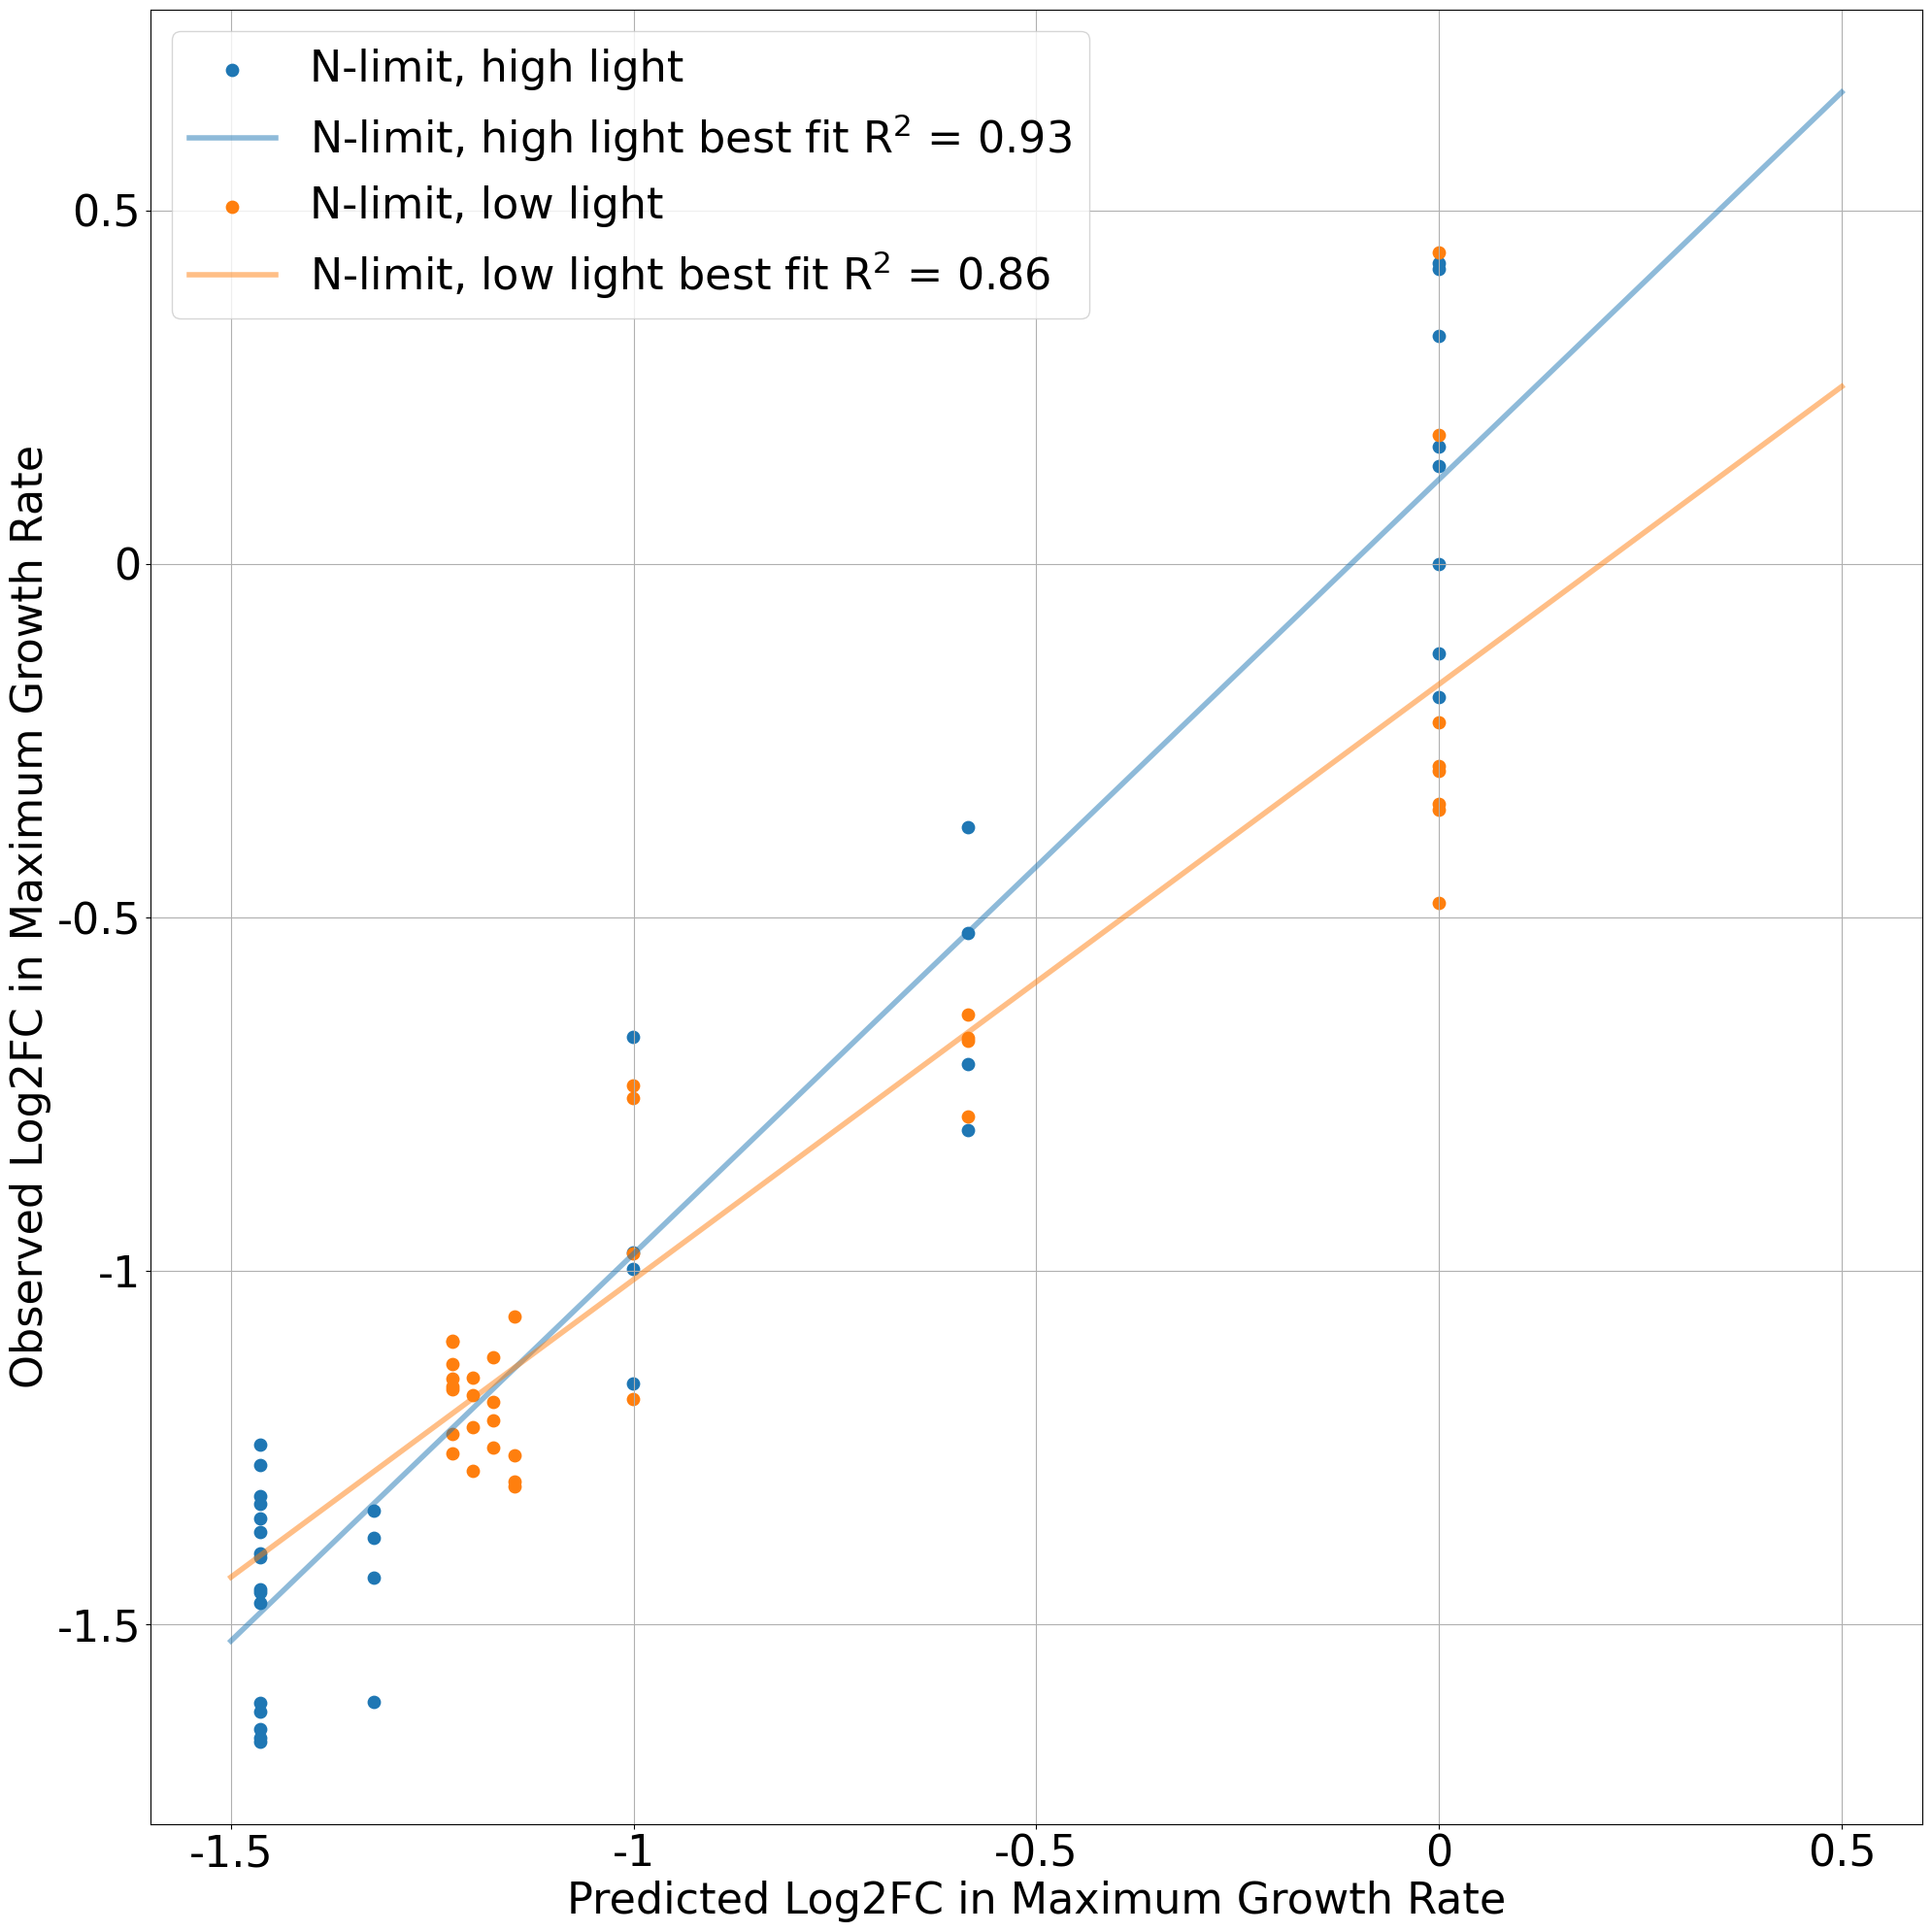

In [74]:
specific = False
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

fs = 32
for c, condition, label_suffix in [
    (0, "N-limit, high light", ""),
    (1, "N-limit, low light", " (low light)"),
]:
    growths_wt = []
    growths_mt = []
    limit_vals_wt = []
    limit_vals_mt = []
    for limit, rep, m in product(
        range(N_LIMIT_VALUES), range(N_REPLICATES_PER_PLATE), range(2)
    ):
        od = cond_data[condition][:, m, rep, limit]

        (
            carrying_capacity,
            growth_rate,
            t_half,
            vshift,
        ) = curve_fits[(condition, limit, rep, m)]
        pcov = covs[(condition, limit, rep, m)]
        mg = max_growth(
            carrying_capacity, growth_rate, vshift=vshift, specific=specific
        )
        mge = max_growth_error(
            pcov, carrying_capacity, growth_rate, vshift=vshift, specific=specific
        )
        if (mge > mg / 2) or np.isnan(mge):
            mg = np.nan
        if m == 0:
            growths_wt.append(mg)
            limit_vals_wt.append(limit)
        else:
            growths_mt.append(mg)
            limit_vals_mt.append(limit)
    growths_wt = np.array(growths_wt)
    growths_mt = np.array(growths_mt)

    dgrowth = np.log2(growths_mt) - np.log2(growths_wt)
    # dgrowth[np.abs(dgrowth) > 3] = np.nan

    box_dict = {}
    fit_vals_with_last_interp = [x for x in fva_fit[c + 1]] + [fva_fit[c + 1][-1]]
    fit_vals_with_last_interp = fit_vals_with_last_interp[::-1]
    for dg, lim in zip(dgrowth, limit_vals_wt):
        box_dict.setdefault(lim, []).append(dg)

    obs_vals = []
    fit_vals = []
    for order, arr in box_dict.items():
        if np.isnan(arr).all():
            continue
        for v in arr:
            obs_vals.append(v)
            fit_vals.append(fit_vals_with_last_interp[order])

    ax.scatter(fit_vals, obs_vals, c=f"C{c}", label=condition, marker="o", s=80)

    # line of best fit
    fit = np.polyfit(fit_vals, obs_vals, deg=1)
    fit = sp.stats.linregress(fit_vals, obs_vals)
    ax.plot(
        [-1.5, -1, -0.5, 0, 0.5],  # 2 * np.arange(N_LIMIT_VALUES) + 0.25,
        fit.intercept + fit.slope * np.array([-1.5, -1, -0.5, 0, 0.5]),
        c=f"C{c}",
        marker="none",
        alpha=0.5,
        linestyle="-",
        linewidth=4,
        label=f"{condition} best fit R$^2$ = {fit.rvalue**2:.2f}",
    )

ax.grid()
ax.set_xlabel("Predicted Log2FC in Maximum Growth Rate", fontsize=fs)
ax.set_ylabel("Observed Log2FC in Maximum Growth Rate", fontsize=fs)
ax.legend(fontsize=fs)
ax.set_yticks([-1.5, -1, -0.5, 0, 0.5])
ax.set_yticklabels([-1.5, -1, -0.5, 0, 0.5], fontsize=fs)
ax.set_xticks([-1.5, -1, -0.5, 0, 0.5])
ax.set_xticklabels([-1.5, -1, -0.5, 0, 0.5], fontsize=fs)
fig.tight_layout()
fig.savefig("figures/log2FC_growth_N-limit_correlation.png")
plt.show()